# Config

In [1]:
import pandas as pd
import geopandas as gpd
import json
import os
import sys
import osmnx as ox
# go up one level from notebooks/ and into src/
sys.path.append(os.path.abspath("../src"))
import schema

In [10]:
target = "Barcelona_1"

# Get data

In [11]:
json_path = "../data/Location/reallocate_all_pilots.geojson"
with open(json_path, "r") as f:
    pilot_geometry = gpd.read_file(f)

#Fix pilot names
pilot_geometry["pilot"] = pilot_geometry["city"] + "_" + pilot_geometry["pilot"].str.lstrip("Pilot")
pilot_geometry.head()

# If a pilot has multiple geometries, dissolve them into one
pilot_geometry = pilot_geometry.dissolve(by="pilot", as_index=False)
print("The shape of the pilot geometry is:", pilot_geometry.shape)
pilot_geometry["pilot"].unique()

The shape of the pilot geometry is: (7, 4)


array(['Barcelona_1', 'Budapest_1', 'Budapest_2', 'Gothenburg_2',
       'Heidelberg_1', 'Utrecht_1', 'Utrecht_2'], dtype=object)

In [12]:
csv_path = "../data/Location/pilot_static_data.csv"
with open(csv_path, "r") as f:
    pilot_coordinates = pd.read_csv(f,sep="	")

print(pilot_coordinates.shape)

pilot_coordinates["lat"] = pilot_coordinates["lat"].astype(str).str.replace(",", ".")
pilot_coordinates["lon"] = pilot_coordinates["lon"].astype(str).str.replace(",", ".")

pilot_coordinates["geometry"] = gpd.points_from_xy(pilot_coordinates.lon, pilot_coordinates.lat)
pilot_coordinates = gpd.GeoDataFrame(pilot_coordinates, geometry="geometry", crs="EPSG:4326")
print(pilot_coordinates.shape)
pilot_coordinates = pilot_coordinates[["City","geometry"]].copy()
pilot_coordinates.head()


(15, 21)
(15, 22)


,City,geometry
0,Gothenburg_1,POINT (11.97456 57.70887)
1,Gothenburg_2,POINT (11.99456 57.72887)
2,Heidelberg_1,POINT (8.67243 49.39875)
3,Heidelberg_2,POINT (8.65243 49.37875)
4,Barcelona_1,POINT (2.18138 41.38878)


In [13]:
json_path = "../data/Dummy/pilot_kpis.json"
with open(json_path, "r") as f:
    pilot_data = json.load(f)

# Flatten the nested structure
rows = []
for pilot, kpis in pilot_data.items():
    for kpi in kpis:
        rows.append({
            "pilot": pilot,
            **kpi  # expands all KPI keys
        })

df_json = pd.DataFrame(rows)
df_json



,pilot,name,theme,kpi_theme_id,unit,baseline_value,post_value
0,Barcelona_1,Number of participants engaged,Engagement,1,counts,57.45,143.59
1,Barcelona_1,reported risk factors affecting perceived road...,road safety,2,counts,93.20,97.83
2,Barcelona_2,Engagement in co-creation,Engagement,1,counts,35.60,40.28
3,Barcelona_2,Increase in users of special services through DRT,Accessibility,3,counts,25.81,132.60
4,Heidelberg_1,Engagement in co-creation,Engagement,1,counts,80.11,112.05
5,Heidelberg_1,Collaboration agreement,Engagement,1,counts,22.06,146.09
6,Heidelberg_2,Pedestrian and Cyclist counts,road safety,2,counts,103.24,47.60
7,Heidelberg_2,Impact on traffic flows,road safety,2,Vehicles/24h,1181.82,1183.40
8,Heidelberg_2,Conversion from impermeable to permeable/veget...,Environment,4,%,30.42,52.48
9,Gothenburg_1,Engagement in co-creation,Engagement,1,Counts,85.92,86.21


# Pull data

In [15]:
# Get the geometry for Barcelona_1
barcelona_geom = pilot_geometry.loc[pilot_geometry["pilot"] == target, "geometry"].iloc[0]

# Query OSM for schools within the geometry
tags = {"amenity": "school"}
schools_gdf = ox.features.features_from_polygon(barcelona_geom, tags)
schools_gdf.head()

geometry amenity  \
element id                                                                      
node    4506626165                           POINT (2.18288 41.40379)  school   
        9381328713                           POINT (2.16346 41.38961)  school   
way     402753028   POLYGON ((2.16784 41.39402, 2.16784 41.3942, 2...  school   
        432504003   POLYGON ((2.1878 41.40622, 2.18758 41.40582, 2...  school   
        454020236   POLYGON ((2.18323 41.40411, 2.18334 41.40402, ...  school   

                    check_date                      name  \
element id                                                 
node    4506626165  2024-09-19               Escola Gaia   
        9381328713  2025-09-04              Perez Iborra   
way     402753028          NaN         Escolàpies Llúria   
        432504003          NaN  Institut Salvador Espriu   
        454020236   2024-09-19       Escola dels Encants   

                                     name:ca name:etymology:wikidata  \
element id                                                             
node    4506626165               Escola Gaia                     NaN   
        9381328713                       NaN                     NaN   
way     402753028                        NaN                     NaN   
        432504003   Institut Salvador Espriu                 Q372549   
        454020236        Escola dels Encants                     NaN   

                         ref    wikidata  addr:city addr:housenumber  ...  \
element id                                                            ...   
node    4506626165   8075611  Q111339488        NaN              NaN  ...   
        9381328713   8005205  Q111595171  Barcelona              321  ...   
way     402753028   08005382         NaN        NaN              NaN  ...   
        432504003    8052797   Q19256811        NaN              NaN  ...   
        454020236    8066462  Q111339440        NaN              NaN  ...   

                                   addr:street  \
element id                                       
node    4506626165                         NaN   
        9381328713  Carrer del Consell de Cent   
way     402753028                          NaN   
        432504003                          NaN   
        454020236                          NaN   

                                            operator  \
element id                                             
node    4506626165                               NaN   
        9381328713                               NaN   
way     402753028                                NaN   
        432504003   Consorci d'Educació de Barcelona   
        454020236                                NaN   

                                               panoramax  \
element id                                                 
node    4506626165  f19c5db0-659c-445b-a15f-462029270e1b   
        9381328713                                   NaN   
way     402753028                                    NaN   
        432504003                                    NaN   
        454020236   4c510600-c418-4545-8ca7-3d9f71d44a5f   

                                             panoramax:0  \
element id                                                 
node    4506626165  076b02ed-8469-4fdb-a1f0-a58f6868383e   
        9381328713                                   NaN   
way     402753028                                    NaN   
        432504003                                    NaN   
        454020236   73e05a4f-89c5-4822-9d50-9862f24cbced   

                                wikimedia_commons                wikipedia  \
element id                                                                   
node    4506626165                            NaN                      NaN   
        9381328713                            NaN                      NaN   
way     402753028                             NaN                      NaN   
        432504003   Category:La Farinera del Clot  

/tmp/ipykernel_155901/4277741638.py:7: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


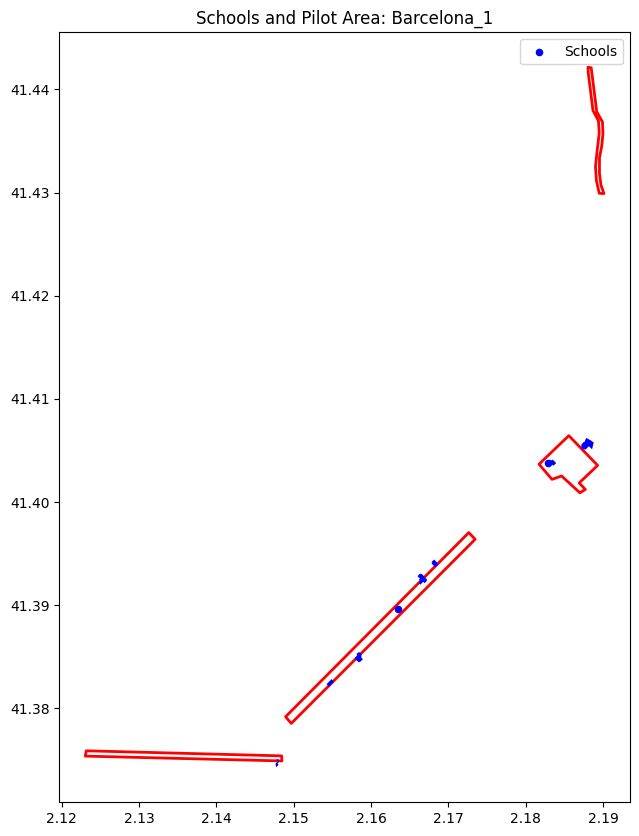

In [17]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
pilot_geometry.loc[pilot_geometry["pilot"] == target].plot(ax=ax, color='none', edgecolor='red', linewidth=2, label='Pilot Area')
schools_gdf.plot(ax=ax, color='blue', markersize=20, label='Schools')
ax.set_title(f"Schools and Pilot Area: {target}")
ax.legend()
plt.show()
